<a href="https://colab.research.google.com/github/rafiqhasan/AI_DL_ML_Repo/blob/master/DL%20E2E/DL_E2E_%7C_Structured_mixed_data_TF_2_Keras_Estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)

device = "gpu"

if device == "tpu":
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:
  strategy = tf.distribute.MirroredStrategy()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.2.0-rc3
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [2]:
df = pd.read_csv("/content/GRIR_GCP_Data.csv")
df_orig = df.copy()
df.head()

,WERKS,SCENARIO,KTOKK,VSTATU,VPATD,EKORG,EKGRP,TOTGRQTY,TOTIRQTY,NODLGR,NODLIR,DIFGRIRD,DIFGRIRV,STATUS
0,ML01,3,1,1,30,1,A,0,80,0,90,-80,-38100,1
1,ML01,3,1,1,30,1,A,0,107,0,177,-107,-41600,0
2,ML01,3,1,1,30,1,A,0,107,0,152,-107,-27600,1
3,ML01,3,1,1,30,1,A,0,96,0,79,-96,-13800,1
4,ML01,3,1,1,30,1,A,0,146,0,192,-146,-73500,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8279 entries, 0 to 8278
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   WERKS     8279 non-null   object
 1   SCENARIO  8279 non-null   int64 
 2   KTOKK     8279 non-null   int64 
 3   VSTATU    8279 non-null   int64 
 4   VPATD     8279 non-null   int64 
 5   EKORG     8279 non-null   int64 
 6   EKGRP     8279 non-null   object
 7   TOTGRQTY  8279 non-null   int64 
 8   TOTIRQTY  8279 non-null   int64 
 9   NODLGR    8279 non-null   int64 
 10  NODLIR    8279 non-null   int64 
 11  DIFGRIRD  8279 non-null   int64 
 12  DIFGRIRV  8279 non-null   int64 
 13  STATUS    8279 non-null   int64 
dtypes: int64(12), object(2)
memory usage: 905.6+ KB


In [4]:
df.describe()

,SCENARIO,KTOKK,VSTATU,VPATD,EKORG,TOTGRQTY,TOTIRQTY,NODLGR,NODLIR,DIFGRIRD,DIFGRIRV,STATUS
count,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000
mean,2.565286,1.497886,1.119097,60.264525,1.333374,65.938398,94.098563,103.070419,89.499819,-28.160164,-6716.334461,0.391835
std,1.096595,0.500026,0.323922,24.387448,0.471447,62.960829,62.449709,81.968329,75.005213,63.224655,22797.380084,0.488190
min,1.000000,1.000000,1.000000,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-200.000000,-75000.000000,0.000000
25%,2.000000,1.000000,1.000000,30.000000,1.000000,0.000000,54.000000,0.000000,10.000000,-56.000000,-9600.000000,0.000000
50%,3.000000,1.000000,1.000000,60.000000,1.000000,55.000000,99.000000,112.000000,82.000000,-2.000000,-546.000000,0.000000
75%,4.000000,2.000000,1.000000,90.000000,2.000000,121.000000,146.000000,172.000000,154.000000,11.000000,5482.000000,1.000000
max,4.000000,2.000000,2.000000,90.000000,2.000000,200.000000,200.000000,268.000000,242.000000,74.000000,59200.000000,1.000000


## **ML Training**( Keras + TF Estimator )

In [5]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.9
traindf = df_orig[msk]
evaldf = df_orig[~msk]

print(len(traindf))
print(len(evaldf))

7453
826


In [0]:
traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)

In [0]:
###############################
##Feature engineering functions
def feature_engg_features(features):
  #Add new features
  features['nodlgrbyvpatd'] = features['NODLGR'] / features['VPATD']

  return(features)

#To be called from TF
def feature_engg(features, label):
  #Add new features
  features = feature_engg_features(features)

  return(features, label)  

In [0]:
###############################
###Data Input pipeline function

# Determine CSV, label, and key columns
#Columns in training sheet -> Can have extra columns too
CSV_COLUMNS = df_orig.columns
LABEL_COLUMN = 'STATUS'

# Set default values for each CSV column( Including Y column )
DEFAULTS = [["ML01"], ['0'], ['0'],["0"],[-1],["-1"],["-1"],[0],[0],[0],[0],[0],[0],[0]]

def make_input_fn(filename, mode, vnum_epochs = None, batch_size = 512):
    def _input_fn(v_test=False):     
        # Create list of files that match pattern
        file_list = tf.io.gfile.glob(filename)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
        else:
            num_epochs = 1 # end-of-input after this        
        
        # Create dataset from file list
        dataset = tf.compat.v1.data.experimental.make_csv_dataset(file_list,
                                                   batch_size=batch_size,
                                                   column_names=CSV_COLUMNS,
                                                   column_defaults=DEFAULTS,
                                                   label_name=LABEL_COLUMN,
                                                   num_epochs = num_epochs,
                                                   num_parallel_reads=30)
        
        #Feature engineering
        dataset = dataset.map(feature_engg)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
            dataset = dataset.shuffle(buffer_size = batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs)
        dataset = dataset.prefetch(buffer_size = batch_size)
        
        #Begins - Uncomment for testing only -----------------------------------------------------<
        if v_test == True:
          x, y = dataset.make_one_shot_iterator().get_next()
          #TF 2.0 has eager execution
          print(x, y)
          
        #End - Uncomment for testing only -----------------------------------------------------<
        return dataset
    return _input_fn

In [9]:
#Test dataset read + Feat Engg function's - output's CSV + Feature engg columns
eval_file = "train*.csv"
fn_d = make_input_fn(filename = eval_file,
                    mode = tf.estimator.ModeKeys.TRAIN,
                    vnum_epochs = 1,
                    batch_size = 10)

fn_d(v_test=True)

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
OrderedDict([('WERKS', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'ML03', b'ML03', b'ML03', b'ML01', b'ML03', b'ML02', b'ML02',
       b'ML03', b'ML02', b'ML02'], dtype=object)>), ('SCENARIO', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'3', b'1', b'3', b'4', b'4', b'2', b'2', b'3', b'2', b'1'],
      dtype=object)>), ('KTOKK', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'2', b'2', b'2', b'2', b'2', b'2', b'1', b'2', b'2', b'1'],
      dtype=object)>), ('VSTATU', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'2'],
      dtype=object)>), ('VPATD', <tf.Tensor: shape=(10,), dtype=int32, numpy=array([60, 60, 90, 90, 30, 30, 60, 60, 90, 90], dtype=int32

<DatasetV1Adapter shapes: (OrderedDict([(WERKS, (None,)), (SCENARIO, (None,)), (KTOKK, (None,)), (VSTATU, (None,)), (VPATD, (None,)), (EKORG, (None,)), (EKGRP, (None,)), (TOTGRQTY, (None,)), (TOTIRQTY, (None,)), (NODLGR, (None,)), (NODLIR, (None,)), (DIFGRIRD, (None,)), (DIFGRIRV, (None,)), (nodlgrbyvpatd, (None,))]), (None,)), types: (OrderedDict([(WERKS, tf.string), (SCENARIO, tf.string), (KTOKK, tf.string), (VSTATU, tf.string), (VPATD, tf.int32), (EKORG, tf.string), (EKGRP, tf.string), (TOTGRQTY, tf.int32), (TOTIRQTY, tf.int32), (NODLGR, tf.int32), (NODLIR, tf.int32), (DIFGRIRD, tf.int32), (DIFGRIRV, tf.int32), (nodlgrbyvpatd, tf.float64)]), tf.int32)>

In [10]:
# Define feature columns
def create_feature_cols():
    werks_c = tf.feature_column.categorical_column_with_vocabulary_list(
            key='WERKS',
            vocabulary_list=['ML01','ML02','ML03'])
    scenario_c = tf.feature_column.categorical_column_with_vocabulary_list(
            key='SCENARIO',
            vocabulary_list=['1','2','3','4'])
    ktokk_c = tf.feature_column.categorical_column_with_vocabulary_list(
            key='KTOKK',
            vocabulary_list=['1','2'])    
    vstatu_c = tf.feature_column.categorical_column_with_vocabulary_list(
            key='VSTATU',
            vocabulary_list=['1','2'])
    ekorg_c = tf.feature_column.categorical_column_with_vocabulary_list(
            key='EKORG',
            vocabulary_list=['1','2'])   
    ekgrp_c = tf.feature_column.categorical_column_with_vocabulary_list(
            key='EKGRP',
            vocabulary_list=['A','B','C'])

    #TF format features
    tf_cols = [
        tf.feature_column.indicator_column(werks_c),
        tf.feature_column.indicator_column(scenario_c),
        tf.feature_column.indicator_column(ktokk_c),
        tf.feature_column.indicator_column(vstatu_c),
        tf.feature_column.indicator_column(ekorg_c),
        tf.feature_column.indicator_column(ekgrp_c),
        tf.feature_column.numeric_column('VPATD'),
        tf.feature_column.numeric_column("TOTGRQTY"),
        tf.feature_column.numeric_column("TOTIRQTY"),
        tf.feature_column.numeric_column("NODLGR"),
        tf.feature_column.numeric_column("NODLIR"),
        tf.feature_column.numeric_column("DIFGRIRD"),
        tf.feature_column.numeric_column("DIFGRIRV"),
        tf.feature_column.numeric_column("nodlgrbyvpatd")
    ]

    #Keras format features
    k_WERKS     = tf.keras.Input(name='WERKS', shape=(1,), dtype=tf.string)
    k_SCENARIO  = tf.keras.Input(name='SCENARIO', shape=(1,), dtype=tf.string)
    k_KTOKK  = tf.keras.Input(name='KTOKK', shape=(1,), dtype=tf.string)
    k_VSTATU  = tf.keras.Input(name='VSTATU', shape=(1,), dtype=tf.string)
    k_EKORG  = tf.keras.Input(name='EKORG', shape=(1,), dtype=tf.string)
    k_EKGRP  = tf.keras.Input(name='EKGRP', shape=(1,), dtype=tf.string)
    k_VPATD  = tf.keras.Input(name='VPATD', shape=(1,), dtype=tf.float32)
    k_TOTGRQTY  = tf.keras.Input(name='TOTGRQTY', shape=(1,), dtype=tf.float32)
    k_TOTIRQTY  = tf.keras.Input(name='TOTIRQTY', shape=(1,), dtype=tf.float32)
    k_NODLGR  = tf.keras.Input(name='NODLGR', shape=(1,), dtype=tf.float32)
    k_NODLIR  = tf.keras.Input(name='NODLIR', shape=(1,), dtype=tf.float32)
    k_DIFGRIRD  = tf.keras.Input(name='DIFGRIRD', shape=(1,), dtype=tf.float32)
    k_DIFGRIRV  = tf.keras.Input(name='DIFGRIRV', shape=(1,), dtype=tf.float32)
    k_nodlgrbyvpatd  = tf.keras.Input(name='nodlgrbyvpatd', shape=(1,), dtype=tf.float32)
    keras_dict_input = {'WERKS': k_WERKS, 'SCENARIO': k_SCENARIO, 'KTOKK' : k_KTOKK,
                        'VSTATU': k_VSTATU, 'EKORG': k_EKORG, 'EKGRP' : k_EKGRP,
                        'VPATD': k_VPATD, 'TOTGRQTY': k_TOTGRQTY, 'TOTIRQTY' : k_TOTIRQTY,
                        'NODLGR': k_NODLGR, 'NODLIR': k_NODLIR, 'DIFGRIRD' : k_DIFGRIRD,
                        'DIFGRIRV': k_DIFGRIRV, 'DIFGRIRV': k_DIFGRIRV, 'nodlgrbyvpatd': k_nodlgrbyvpatd
                        }

    return({'TF' : tf_cols, 'K' : keras_dict_input})

create_feature_cols()

{'K': {'DIFGRIRD': <tf.Tensor 'DIFGRIRD:0' shape=(None, 1) dtype=float32>,
  'DIFGRIRV': <tf.Tensor 'DIFGRIRV:0' shape=(None, 1) dtype=float32>,
  'EKGRP': <tf.Tensor 'EKGRP:0' shape=(None, 1) dtype=string>,
  'EKORG': <tf.Tensor 'EKORG:0' shape=(None, 1) dtype=string>,
  'KTOKK': <tf.Tensor 'KTOKK:0' shape=(None, 1) dtype=string>,
  'NODLGR': <tf.Tensor 'NODLGR:0' shape=(None, 1) dtype=float32>,
  'NODLIR': <tf.Tensor 'NODLIR:0' shape=(None, 1) dtype=float32>,
  'SCENARIO': <tf.Tensor 'SCENARIO:0' shape=(None, 1) dtype=string>,
  'TOTGRQTY': <tf.Tensor 'TOTGRQTY:0' shape=(None, 1) dtype=float32>,
  'TOTIRQTY': <tf.Tensor 'TOTIRQTY:0' shape=(None, 1) dtype=float32>,
  'VPATD': <tf.Tensor 'VPATD:0' shape=(None, 1) dtype=float32>,
  'VSTATU': <tf.Tensor 'VSTATU:0' shape=(None, 1) dtype=string>,
  'WERKS': <tf.Tensor 'WERKS:0' shape=(None, 1) dtype=string>,
  'nodlgrbyvpatd': <tf.Tensor 'nodlgrbyvpatd:0' shape=(None, 1) dtype=float32>},
 'TF': [IndicatorColumn(categorical_column=Vocabular

## **Keras Model**

**For mixed columns:**
When dataset contains: Categorical + Numerical + Textual columns. We might have to split the input into multiple input layers which themselves connect to further layers which finally concatenate as one.

In [0]:
#Create model
params_default = {
    'lr' : 0.01,
    'beta_1' : 0.99,
    'beta_2' : 0.999,
    'epsilon' : 1e-08,
    'decay' : 0.01,
    'hidden_layers' : 1
}

def create_keras_model(params, feature_cols):
    # model = tf.keras.Sequential()

    #Input Feature layers
    #Tensorflow style feature columns
    ###Create dense layer A for one set of columns
    A = tf.keras.layers.DenseFeatures(feature_columns=feature_cols['TF'][0:6])({'WERKS' : feature_cols['K']['WERKS'],
                                                                                'SCENARIO': feature_cols['K']['SCENARIO'],
                                                                                'KTOKK': feature_cols['K']['KTOKK'],
                                                                                'VSTATU': feature_cols['K']['VSTATU'],
                                                                                'EKORG': feature_cols['K']['EKORG'],
                                                                                'EKGRP': feature_cols['K']['EKGRP']})
    
    ###Create dense layer B for other set of columns
    B = tf.keras.layers.DenseFeatures(feature_columns=feature_cols['TF'][6:])({'VPATD' : feature_cols['K']['VPATD'],
                                                                              'TOTGRQTY': feature_cols['K']['TOTGRQTY'],
                                                                              'TOTIRQTY': feature_cols['K']['TOTIRQTY'],
                                                                              'NODLGR': feature_cols['K']['NODLGR'],
                                                                              'NODLIR': feature_cols['K']['NODLIR'],
                                                                              'DIFGRIRD': feature_cols['K']['DIFGRIRD'],
                                                                              'DIFGRIRV': feature_cols['K']['DIFGRIRV'],
                                                                              'nodlgrbyvpatd': feature_cols['K']['nodlgrbyvpatd']})
    
    
    #This Dense layer connects to input layer A
    x_a = tf.keras.layers.Dense(32, activation='relu',kernel_initializer='he_uniform')(A)
    x_a = tf.keras.layers.BatchNormalization()(x_a)

    #This Dense layer connects to input layer B
    x_b = tf.keras.layers.Dense(32, activation='relu',kernel_initializer='he_uniform')(B)
    x_b = tf.keras.layers.BatchNormalization()(x_b)

    #Concatenate x_a and x_b
    x = tf.keras.layers.concatenate([x_a, x_b])

    for l_ in range(params['hidden_layers']):
        x = tf.keras.layers.Dense(32, activation='relu',kernel_initializer='he_uniform')(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(feature_cols['K'], x)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr= params['lr'], beta_1=params['beta_1'], 
                                        beta_2=params['beta_2'], epsilon=params['epsilon'])

    #Compile model
    model.compile(loss='binary_crossentropy',  optimizer=opt, metrics =['accuracy'])

    #Print Summary
    print(model.summary())
    return model

In [0]:
def keras_train_and_evaluate(model, train_dataset, validation_dataset):
  #Add callbacks
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.0001, verbose = 1)
  
  #Train and Evaluate
  out = model.fit(train_dataset, 
                  validation_data = validation_dataset,
                  epochs=100,
                  validation_steps = 2,   ###Has to be passed - Cant help it :)
                  steps_per_epoch = 10,   ###Has to be passed - Cant help it :) [ Number of batches per epoch ]
                  callbacks=[reduce_lr, keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EKGRP (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
EKORG (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
KTOKK (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
SCENARIO (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

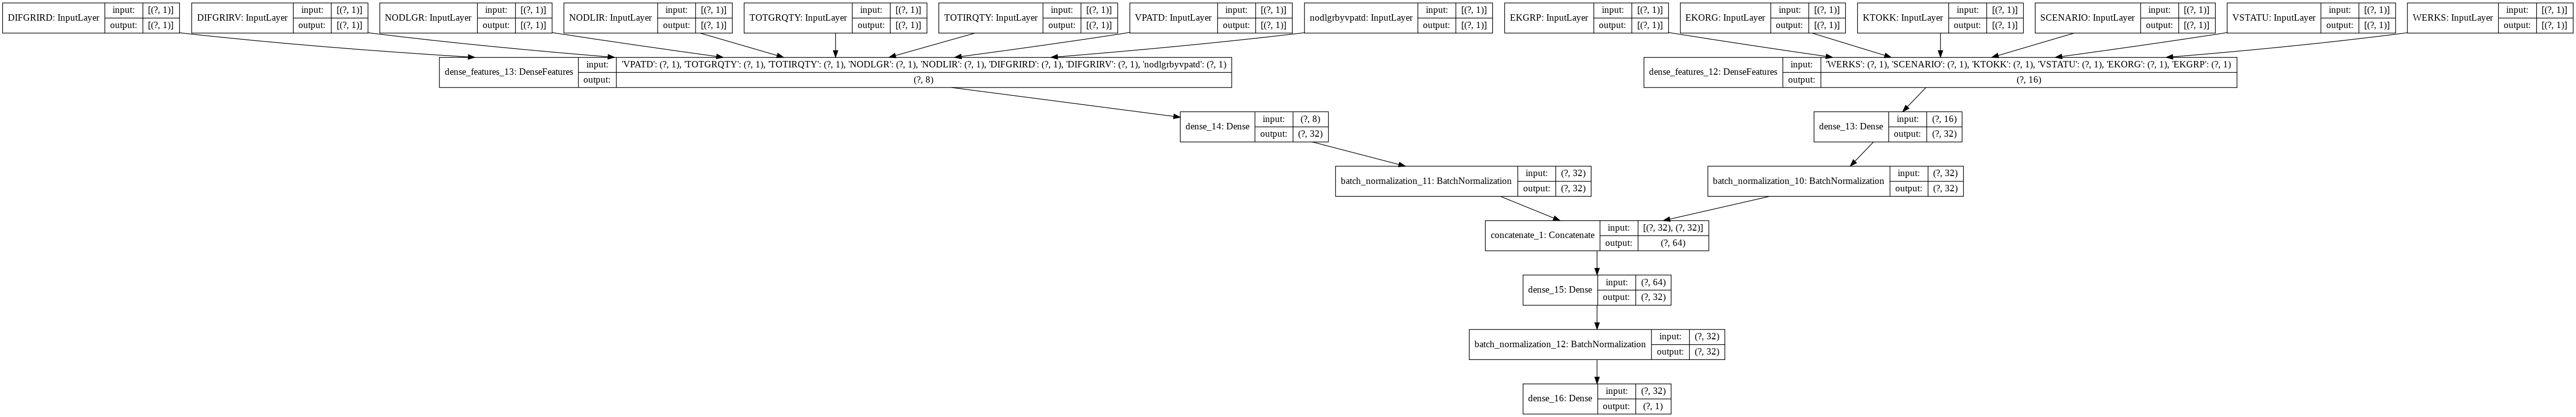

In [69]:
# epochs = 100
#Create dataset input functions
train_dataset = make_input_fn(filename = 'train*.csv',
                    mode = tf.estimator.ModeKeys.TRAIN,
                    # vnum_epochs = epochs,
                    batch_size = 512)()

validation_dataset = make_input_fn(filename = 'eval*.csv',
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 512)()

m_ = create_keras_model(params = params_default, feature_cols = create_feature_cols())
tf.keras.utils.plot_model(m_, show_shapes=True)

In [70]:
keras_train_and_evaluate(m_, train_dataset, validation_dataset)

Epoch 1/100
10/10 [==============================] - 1s 103ms/step - loss: 0.5564 - accuracy: 0.7123 - val_loss: 0.8921 - val_accuracy: 0.6158 - lr: 0.0100
Epoch 2/100
10/10 [==============================] - 0s 18ms/step - loss: 0.3890 - accuracy: 0.8268 - val_loss: 1.0309 - val_accuracy: 0.6570 - lr: 0.0100
Epoch 3/100
10/10 [==============================] - 0s 17ms/step - loss: 0.3773 - accuracy: 0.8246 - val_loss: 0.8990 - val_accuracy: 0.7164 - lr: 0.0100
Epoch 4/100
10/10 [==============================] - 0s 20ms/step - loss: 0.3350 - accuracy: 0.8520 - val_loss: 0.7753 - val_accuracy: 0.7406 - lr: 0.0100
Epoch 5/100
10/10 [==============================] - 0s 20ms/step - loss: 0.3226 - accuracy: 0.8564 - val_loss: 0.6617 - val_accuracy: 0.7491 - lr: 0.0100
Epoch 6/100
10/10 [==============================] - 0s 20ms/step - loss: 0.2862 - accuracy: 0.8783 - val_loss: 0.6688 - val_accuracy: 0.7564 - lr: 0.0100
Epoch 7/100
10/10 [==============================] - 0s 19ms/step - l

## **Keras to TF 2 Estimator**

In [0]:
# Serving function for external call
def serving_fn():
    feature_placeholders = {
        'WERKS' : tf.convert_to_tensor(tf.Variable([''], shape=[None])),
        'SCENARIO' : tf.convert_to_tensor(tf.Variable([''], shape=[None])),
        'KTOKK' : tf.convert_to_tensor(tf.Variable([''], shape=[None])),
        'VSTATU' : tf.convert_to_tensor(tf.Variable([''], shape=[None])),
        'EKORG' : tf.convert_to_tensor(tf.Variable([''], shape=[None])),
        'EKGRP' : tf.convert_to_tensor(tf.Variable([''], shape=[None])),
        'VPATD' : tf.convert_to_tensor(tf.Variable([0], shape=[None])),
        'TOTGRQTY' : tf.convert_to_tensor(tf.Variable([0], shape=[None])),
        'TOTIRQTY' : tf.convert_to_tensor(tf.Variable([0], shape=[None])),
        'NODLGR' : tf.convert_to_tensor(tf.Variable([0], shape=[None])),
        'NODLIR' : tf.convert_to_tensor(tf.Variable([0], shape=[None])),
        'DIFGRIRD' : tf.convert_to_tensor(tf.Variable([0], shape=[None])),
        'DIFGRIRV' : tf.convert_to_tensor(tf.Variable([0], shape=[None]))
    }

    #Features with transformation logic
    features = {
                key: tf.expand_dims(tensor, -1)
                for key, tensor in feature_placeholders.items()
            }

    #feat_changed = add_engineered(features.copy())
    return tf.estimator.export.ServingInputReceiver(feature_engg_features(features), feature_placeholders )

In [0]:
# Create estimator train and evaluate function
def est_train_and_evaluate(keras_model, output_dir, num_train_steps, train_file, eval_file): 
    run_config = tf.estimator.RunConfig(save_checkpoints_secs = 40, 
                                        keep_checkpoint_max = 10)
    
    #Convert Keras model to TF estimator
    estimator = tf.keras.estimator.model_to_estimator(keras_model=keras_model, config=run_config,
                                                    model_dir = 'model' )

    train_spec = tf.estimator.TrainSpec(input_fn =  make_input_fn(filename = train_file,
                                                    mode = tf.estimator.ModeKeys.TRAIN,
                                                    batch_size = 512),
                                                    max_steps = num_train_steps
                                    )
    
    #Create exporter
    exp = tf.estimator.LatestExporter("decision", serving_fn)
    eval_spec = tf.estimator.EvalSpec(input_fn =    make_input_fn(filename = eval_file,
                                                    mode = tf.estimator.ModeKeys.EVAL,
                                                    batch_size = 512),
                                      steps = None,
                                      exporters = exp,
                                      start_delay_secs = 20, # start evaluating after N seconds, 
                                      throttle_secs = 45)  # evaluate every N seconds
                                
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
    return(estimator)

In [73]:
#tf.logging.set_verbosity(tf.logging.WARN)
train_file = "train*.csv"
eval_file = "eval*.csv"

m_ = create_keras_model(params = params_default, feature_cols = create_feature_cols())
e_ = est_train_and_evaluate(m_, None, 5000, train_file, eval_file)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EKGRP (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
EKORG (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
KTOKK (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
SCENARIO (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [0]:
##Try prediction:
def predict_model():
  outs = []
  y = e_.predict(make_input_fn(filename = eval_file,
                            mode = tf.estimator.ModeKeys.EVAL))
  for i, b in enumerate(y):
    if i == 10:
      break
    else:  
      outs.append(b[list(b.keys())[0]][0])

  return(outs)

predict_model()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[1.8230005e-06,
 0.020859133,
 0.0044516246,
 0.006418933,
 0.001197777,
 0.7826696,
 0.019857964,
 6.003437e-05,
 1.0432252e-06,
 0.00047716044]